<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/nih_patent_biogpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install transformers -q
# !pip install sacremoses -q
!pip install scann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.2 MB/s eta 0:00:00


In [3]:
import numpy as np 
import os 
# import pickle
# from transformers import AutoTokenizer, BioGptModel
# import torch
import os 
import json
from typing import List
import collections
import numpy as np
import pandas as pd
import scann
import joblib
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
os.listdir('drive/MyDrive/transfer/patent/patent_raw/nih')

['nih_patents_ada_embeddings.json',
 'embeddings.npy',
 'nih_title',
 'nih_abstract',
 'nih_data.ipynb',
 'data_nih_abstarct_biogpt.npy',
 'data_nih_abstarct_biogpt_norm.npy',
 'data_nih_title_biogpt.npy',
 'data_nih_title_biogpt_norm.npy']

In [5]:
# titles_file = 'drive/MyDrive/transfer/patent/patent_raw/nih/nih_title'
# file = open(titles_file, 'rb')
# title_raw = pickle.load(file)
# file.close()

# abstract_file = 'drive/MyDrive/transfer/patent/patent_raw/nih/nih_abstract'
# file = open(abstract_file, 'rb')
# abstract_raw = pickle.load(file)
# file.close()

In [6]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt");
# model = BioGptModel.from_pretrained("microsoft/biogpt");

In [7]:
# def normalizer(x):     
#     normalized_vector = x / np.linalg.norm(x)
#     return normalized_vector

# class BioGptModel:
    
#     def __init__(self, model, tokenizer):
#         # self.sentence = sentence
#         self.model = model
#         self.tokenizer = tokenizer

#     def sentence_vectors(self,sentence):
#         inputs = self.tokenizer(sentence, return_tensors = 'pt')
#         w_vectors = self.model(**inputs)

#         # return w_vectors
#         token_embeddings = w_vectors[0] #First element of model_output contains all token embeddings
#         input_mask_expanded = inputs.attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#         return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# gpt_class = BioGptModel(model, tokenizer)
     


# def sentence_encoder(data):
#     vectors = []
#     normalized_vectors = []
#     for i in range(len(data)):
#         sentence_vectors = gpt_class.sentence_vectors(data[i]).detach().numpy()
#         vectors.append(sentence_vectors)
#         normalized_vectors.append(normalizer(sentence_vectors))

#     vectors = np.squeeze(np.array(vectors))
#     normalized_vectors = np.squeeze(np.array(normalized_vectors))

#     return vectors, normalized_vectors    

In [8]:
# abst_vectors, abst_vectors_norm = sentence_encoder(abstract_raw) 
# title_vectors, title_vectors_norm = sentence_encoder(title_raw) 

In [9]:
# np.save('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_abstarct_biogpt.npy',abst_vectors)
# np.save('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_abstarct_biogpt_norm.npy',abst_vectors_norm)

# np.save('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_title_biogpt.npy',title_vectors)
# np.save('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_title_biogpt_norm.npy',title_vectors_norm)

In [10]:
abst_vectors = np.load('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_abstarct_biogpt.npy')
abst_vectors_norm = np.load('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_abstarct_biogpt_norm.npy')

title_vectors = np.load('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_title_biogpt.npy')
title_vectors_norm = np.load('drive/MyDrive/transfer/patent/patent_raw/nih/data_nih_title_biogpt_norm.npy')

In [11]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr  

In [12]:
print(title_vectors_norm.shape)
print(abst_vectors_norm.shape)



def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save('./patent_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save('./patent_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = svd_.inverse_transform(content_vectors_svd)
    inverse_title = svd_.inverse_transform(title_vectors_svd)

    np.save('./patent_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save('./patent_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

(3243, 1024)
(3243, 1024)


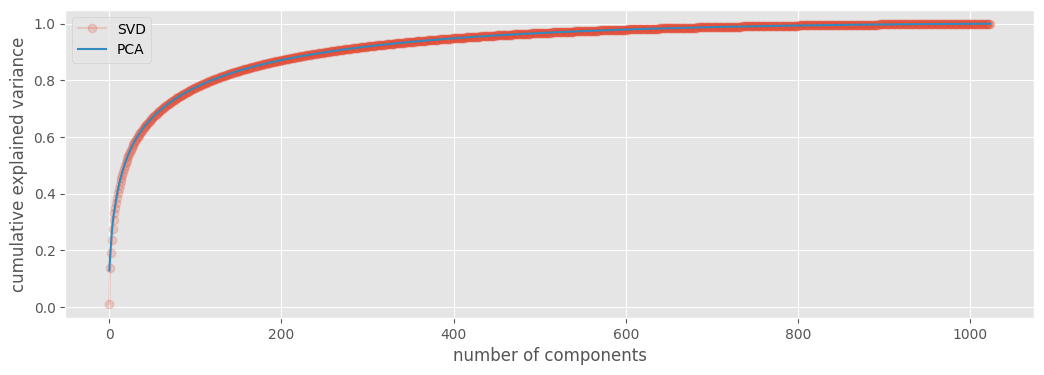

In [13]:
pca = PCA().fit(abst_vectors_norm)
pca_var = np.cumsum(pca.explained_variance_ratio_)

svd_content = TruncatedSVD(n_iter= 25, n_components = 1024 ).fit(abst_vectors_norm)
svd_var = np.cumsum(svd_content.explained_variance_ratio_)
     
plt.figure(figsize = (12.5,4))
plt.plot(svd_var, marker = 'o', alpha =0.2)
plt.plot(pca_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])

In [14]:
print('PCA 100% :',np.where(np.array(pca_var) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var) >= 0.90)[0][0])
print('SVD 82% :',np.where(np.array(svd_var) >= 0.82)[0][0])
print('SVD 82% :',np.where(np.array(svd_var) >= 0.82)[0][0])

PCA 100% : 732
SVD 100% : 732
PCA 95% : 407
SVD 95% : 408
PCA 90% : 253
SVD 90% : 253
SVD 82% : 137
SVD 82% : 137


In [15]:
pca_reducer(732, abst_vectors_norm, title_vectors_norm)
svd_reducer(732, abst_vectors_norm, title_vectors_norm)

pca_reducer(407, abst_vectors_norm, title_vectors_norm)
svd_reducer(407, abst_vectors_norm, title_vectors_norm)

pca_reducer(253, abst_vectors_norm, title_vectors_norm)
svd_reducer(253, abst_vectors_norm, title_vectors_norm)

# pca_reducer(165, abst_vectors_norm, title_vectors_norm)
# svd_reducer(165, abst_vectors_norm, title_vectors_norm)

In [16]:
# abstract_pca_59 = np.load('./patent_abst_vectors_norm_pca_59.npy')
abstract_pca_253 = np.load('./patent_abst_vectors_norm_pca_253.npy')
abstract_pca_407 = np.load('./patent_abst_vectors_norm_pca_407.npy')
abstract_pca_732 = np.load('./patent_abst_vectors_norm_pca_732.npy')

# abstract_svd_59 = np.load('./patent_abst_vectors_norm_svd_59.npy')
abstract_svd_253 = np.load('./patent_abst_vectors_norm_svd_253.npy')
abstract_svd_407 = np.load('./patent_abst_vectors_norm_svd_407.npy')
abstract_svd_732 = np.load('./patent_abst_vectors_norm_svd_732.npy')

# title_pca_59 = np.load('./patent_title_vectors_norm_pca_59.npy')
title_pca_253 = np.load('./patent_title_vectors_norm_pca_253.npy')
title_pca_407 = np.load('./patent_title_vectors_norm_pca_407.npy')
title_pca_732 = np.load('./patent_title_vectors_norm_pca_732.npy')

# title_svd_59 = np.load('./patent_title_vectors_norm_svd_59.npy')
title_svd_253 = np.load('./patent_title_vectors_norm_svd_253.npy')
title_svd_407 = np.load('./patent_title_vectors_norm_svd_407.npy')
title_svd_732 = np.load('./patent_title_vectors_norm_svd_732.npy')

In [17]:
searcher_raw = scann.scann_ops_pybind.builder(abst_vectors_norm, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_732 = scann.scann_ops_pybind.builder(abstract_pca_732, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_407 = scann.scann_ops_pybind.builder(abstract_pca_407, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_253 = scann.scann_ops_pybind.builder(abstract_pca_253, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

# searcher_pca_165 = scann.scann_ops_pybind.builder(abstract_pca_165, 50, "dot_product").tree(
#     num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
#     2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

searcher_svd_732 = scann.scann_ops_pybind.builder(abstract_svd_732, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_407 = scann.scann_ops_pybind.builder(abstract_svd_407, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_253 = scann.scann_ops_pybind.builder(abstract_svd_253, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
     
# searcher_svd_165 = scann.scann_ops_pybind.builder(abstract_svd_165, 50, "dot_product").tree(
#     num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
#     2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

In [18]:
raw_idx = []
# reduced_idx_pca_59 = []
# reduced_idx_svd_59 = []
reduced_idx_pca_732 = []
reduced_idx_svd_732 = []
reduced_idx_pca_407 = []
reduced_idx_svd_407 = []
reduced_idx_pca_253 = []
reduced_idx_svd_253 = []
for i in range(len(abst_vectors_norm)):
    raw_idx.append(searcher_raw.search(title_vectors_norm[i])[0])
    # reduced_idx_pca_59.append(searcher_pca_59.search(title_pca_59[i])[0])
    # reduced_idx_svd_59.append(searcher_svd_59.search(title_svd_59[i])[0])
    reduced_idx_pca_253.append(searcher_pca_253.search(title_pca_253[i])[0])
    reduced_idx_svd_253.append(searcher_svd_253.search(title_svd_253[i])[0])
    reduced_idx_pca_407.append(searcher_pca_407.search(title_pca_407[i])[0])
    reduced_idx_svd_407.append(searcher_svd_407.search(title_svd_407[i])[0])
    reduced_idx_pca_732.append(searcher_pca_732.search(title_pca_732[i])[0])
    reduced_idx_svd_732.append(searcher_svd_732.search(title_svd_732[i])[0])

In [19]:


k = [1,3,5,10,15,20,30]
ap_pca_253, hit_pca_253, mrr_pca_253 = metrics_calculator(raw_idx,reduced_idx_pca_253, k )
ap_svd_253, hit_svd_253, mrr_svd_253 = metrics_calculator(raw_idx,reduced_idx_svd_253, k )

ap_pca_407, hit_pca_407, mrr_pca_407 = metrics_calculator(raw_idx,reduced_idx_pca_407, k )
ap_svd_407, hit_svd_407, mrr_svd_407 = metrics_calculator(raw_idx,reduced_idx_svd_407, k )

ap_pca_732, hit_pca_732, mrr_pca_732 = metrics_calculator(raw_idx,reduced_idx_pca_732, k )
ap_svd_732, hit_svd_732, mrr_svd_732 = metrics_calculator(raw_idx,reduced_idx_svd_732, k )

# ap_pca_107, hit_pca_107, mrr_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_165, k )
# ap_svd_107, hit_svd_107, mrr_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_165, k )     
     


<ipython-input-11-79f078fc1687>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


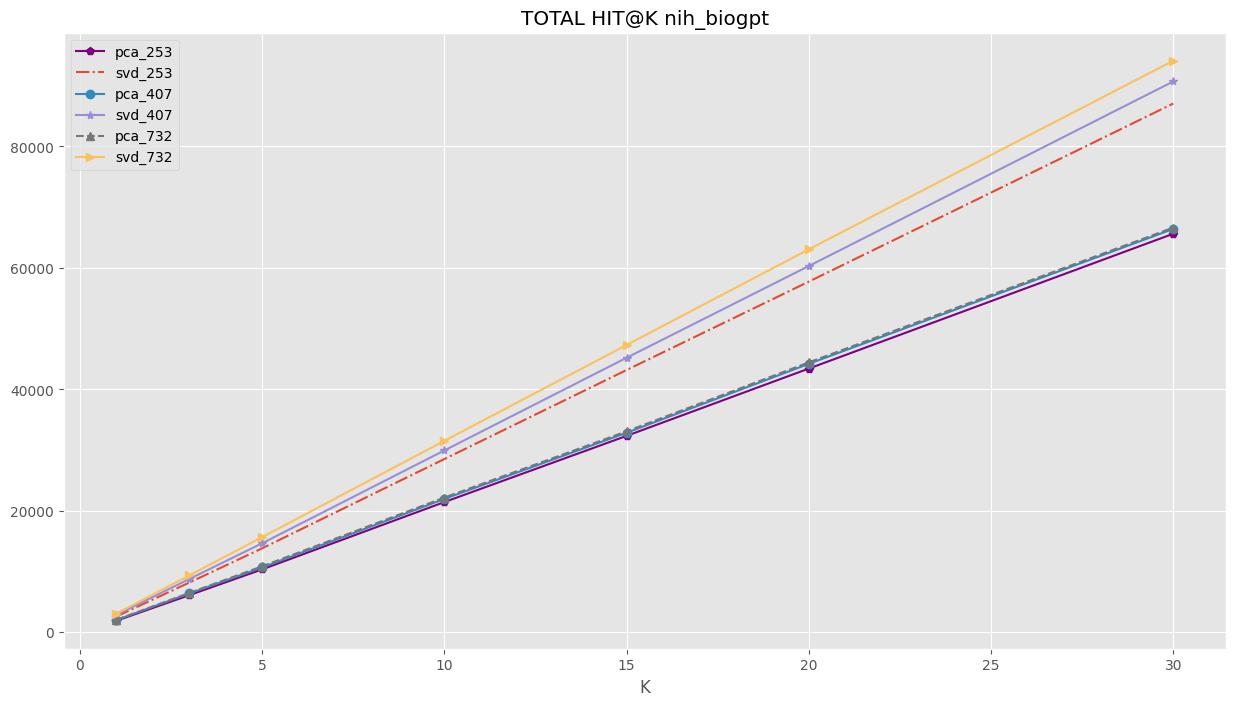

In [20]:


# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_253, '-p', color = 'purple')
plt.plot(k,hit_svd_253, '-.')
plt.plot(k,hit_pca_407, '-o')
plt.plot(k,hit_svd_407, '-*')
plt.plot(k,hit_pca_732, '--^')
plt.plot(k,hit_svd_732, '>-')
# plt.scatter(k,hit_pca_107, marker ='s',color= 'green')
# plt.plot(k,hit_svd_107, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K nih_biogpt')
plt.legend(['pca_253','svd_253','pca_407','svd_407','pca_732','svd_732'])
plt.xlabel('K');
     


In [21]:
print(hit_svd_253)
print(hit_svd_407)
print(hit_svd_732)

[2625, 8202, 13845, 28543, 43200, 57752, 87075]
[2880, 8790, 14676, 29961, 45215, 60320, 90706]
[3095, 9383, 15682, 31540, 47316, 63072, 94121]
